# Introduction to line 144
144 is a telephone number implemented throughout the Argentine Republic to report domestic violence. The datasets studied in this notebook contain the records of the calls to this service.

### Imports

In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sys

### Load data source
We have 3 datasets with data of 2020, 2021, 2022

In [37]:
years = [2020, 2021, 2022, 2023]
data_dict = {}

for year in years:
    data_dict[year] = pd.read_csv(f'./data/linea144-{year}.csv', parse_dates=['fecha'])

data = pd.concat(data_dict, ignore_index=True)

# Excluding last column with no data
data = data.iloc[:,:-1]

assert data.shape == (84861, 19)
assert data.fecha.dtype == 'datetime64[ns]', "'fecha' must be a datetime64 type"

### Filling in missing categorical variables by using the mode
* [Heres how to fill in missing values in a dataset](https://thecleverprogrammer.com/2023/03/14/heres-how-to-fill-in-missing-values-in-a-dataset/) 

#### Summary from the article

> So the first step is to see if your data has missing values. If your data has missing values, you need to check the distribution of each numerical variable (with missing values). If the values in the numerical variables are missing, use the Mean value if the variable is in a normal distribution. Otherwise, choose Median. And if the variable is categorical or discrete, you can select mode. So you need to choose a different measure for each variable. I hope you liked this article on how to fill in missing values in your data. Feel free to ask valuable questions in the comments section below.

In [38]:
# Filling nan rows with mode
def fill_with_mode_the_nan_values(field):

    # n records NaN to theis field 
    fields_nan = data[field].isna().sum()
    print(f'Processing records NaN to {field}: {fields_nan}')
    
    if fields_nan > 0:
        # filling using the mode, like shown in link above
        field_mode = data[field].mode()[0]

        data[field].fillna(field_mode, inplace=True)

fields = ['prov_residencia_persona_en_situacion_violencia', 'genero_persona_en_situacion_de_violencia', \
          'pais_nacimiento_persona_en_situacion_de_violencia', 'vinculo_con_la_persona_agresora', \
            'genero_de_la_persona_agresora']

[fill_with_mode_the_nan_values(field) for field in fields]

Processing records NaN to prov_residencia_persona_en_situacion_violencia: 1229
Processing records NaN to genero_persona_en_situacion_de_violencia: 1776
Processing records NaN to pais_nacimiento_persona_en_situacion_de_violencia: 28706
Processing records NaN to vinculo_con_la_persona_agresora: 3192
Processing records NaN to genero_de_la_persona_agresora: 8737


[None, None, None, None, None]

### Filling numeric values (edad_persona_en_situacion_de_violencia) using the median
* **Mean**, when we have a normal distribution
* **Median**, otherwise

Kurtosis: 1.315091416195283
There are/was 16402 missing values to field "edad_persona_en_situacion_de_violencia"


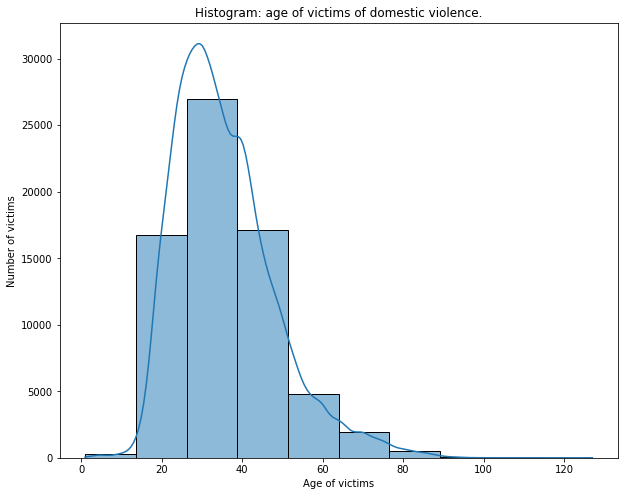

In [39]:
# Histogram: distribution ins't normal

# Calculate kurtosis
print(f'Kurtosis: {data.edad_persona_en_situacion_de_violencia.kurtosis()}')

# Count of missing values
print(f'There are/was {data.edad_persona_en_situacion_de_violencia.isna().sum()} missing values to field "edad_persona_en_situacion_de_violencia"')

plt.figure(figsize=(10, 8))
f = sns.histplot(data['edad_persona_en_situacion_de_violencia'], bins=10, kde=True)
f.set_title('Histogram: age of victims of domestic violence.')
f.set_xlabel("Age of victims")
f.set_ylabel("Number of victims")
plt.show()

# Calculate the median
age_median = data.edad_persona_en_situacion_de_violencia.median()

# Filling data with the mean
data.fillna(age_median, inplace=True)


### Types and modalities whose values are boolean

In [40]:


# 1. Define wich fields will be processed 
boolean_fields = ['tipo_de_violencia_fisica', 'tipo_de_violencia_psicologica', 'tipo_de_violencia_sexual', \
                    'tipo_de_violencia_economica_y_patrimonial', 'tipo_de_violencia_simbolica', 'tipo_de_violencia_domestica',
                    'modalidad_de_violencia_institucional', 'modalidad_de_violencia_laboral', \
                    'modalidad_violencia_contra_libertad_reproductiva', 'modalidad_de_violencia_obstetrica', \
                    'modalidad_de_violencia_mediatica', 'modalidad_de_violencia_otras']

# 2. View and confirmation that they are boolean
def fields_view_validation(field):
    print(f"Types for field '{field}': {data[field].unique()}")

# 3. Show
[fields_view_validation(field) for field in boolean_fields]

# 4. Cast to boolean 
mapping = {'Si': True, 'SI': True, 'No': False, 'NO': False}

for field in boolean_fields:
    data[field] = data[field].map(mapping)


Types for field 'tipo_de_violencia_fisica': ['Si' 'No']
Types for field 'tipo_de_violencia_psicologica': ['Si' 'No']
Types for field 'tipo_de_violencia_sexual': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_economica_y_patrimonial': ['No' 'Si']
Types for field 'tipo_de_violencia_simbolica': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_domestica': ['Si' 'No']
Types for field 'modalidad_de_violencia_institucional': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_laboral': ['No' 'Si' 'SI']
Types for field 'modalidad_violencia_contra_libertad_reproductiva': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_obstetrica': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_mediatica': ['No' 'Si']
Types for field 'modalidad_de_violencia_otras': ['No' 'Si']


## Show the information

### Boolean fields: Mapping fields to a readable title

In [41]:


boolean_fields_titles = ['Type of Physical Violence',
'Type of Psychological Violence',
'Type of Sexual Violence',
'Type of Economic And Patrimonial Violence',
'Type of Symbolic Violence',
'Type of Domestic Violence',
'Modality of Institutional Violence',
'Type of Workplace Violence',
'Modality Violence Against Reproductive Freedom',
'Modality of Obstetric Violence',
'Modality of Media Violence',
'Modality of Violence Other']

boolean_fields_dict = {}
for (id, title) in zip(boolean_fields, boolean_fields_titles):
    boolean_fields_dict[id] = title

# Validating
data[boolean_fields].sample(10)

,tipo_de_violencia_fisica,tipo_de_violencia_psicologica,tipo_de_violencia_sexual,tipo_de_violencia_economica_y_patrimonial,tipo_de_violencia_simbolica,tipo_de_violencia_domestica,modalidad_de_violencia_institucional,modalidad_de_violencia_laboral,modalidad_violencia_contra_libertad_reproductiva,modalidad_de_violencia_obstetrica,modalidad_de_violencia_mediatica,modalidad_de_violencia_otras
14074,True,True,False,True,False,True,False,False,False,False,False,False
21687,False,True,False,True,False,True,False,False,False,False,False,False
40725,True,True,False,False,False,True,False,False,False,False,False,False
84231,False,True,False,False,False,False,False,False,False,False,False,False
10600,True,True,False,False,True,True,False,False,False,False,False,False
66578,False,True,False,False,False,True,False,False,False,False,False,False
30284,False,True,False,False,True,False,False,False,False,False,False,False
35232,True,True,False,False,True,True,False,False,False,False,False,False
66889,True,True,False,True,False,True,False,False,False,False,False,False
67683,True,True,False,True,False,True,False,False,False,False,False,False


### Showing boolean features

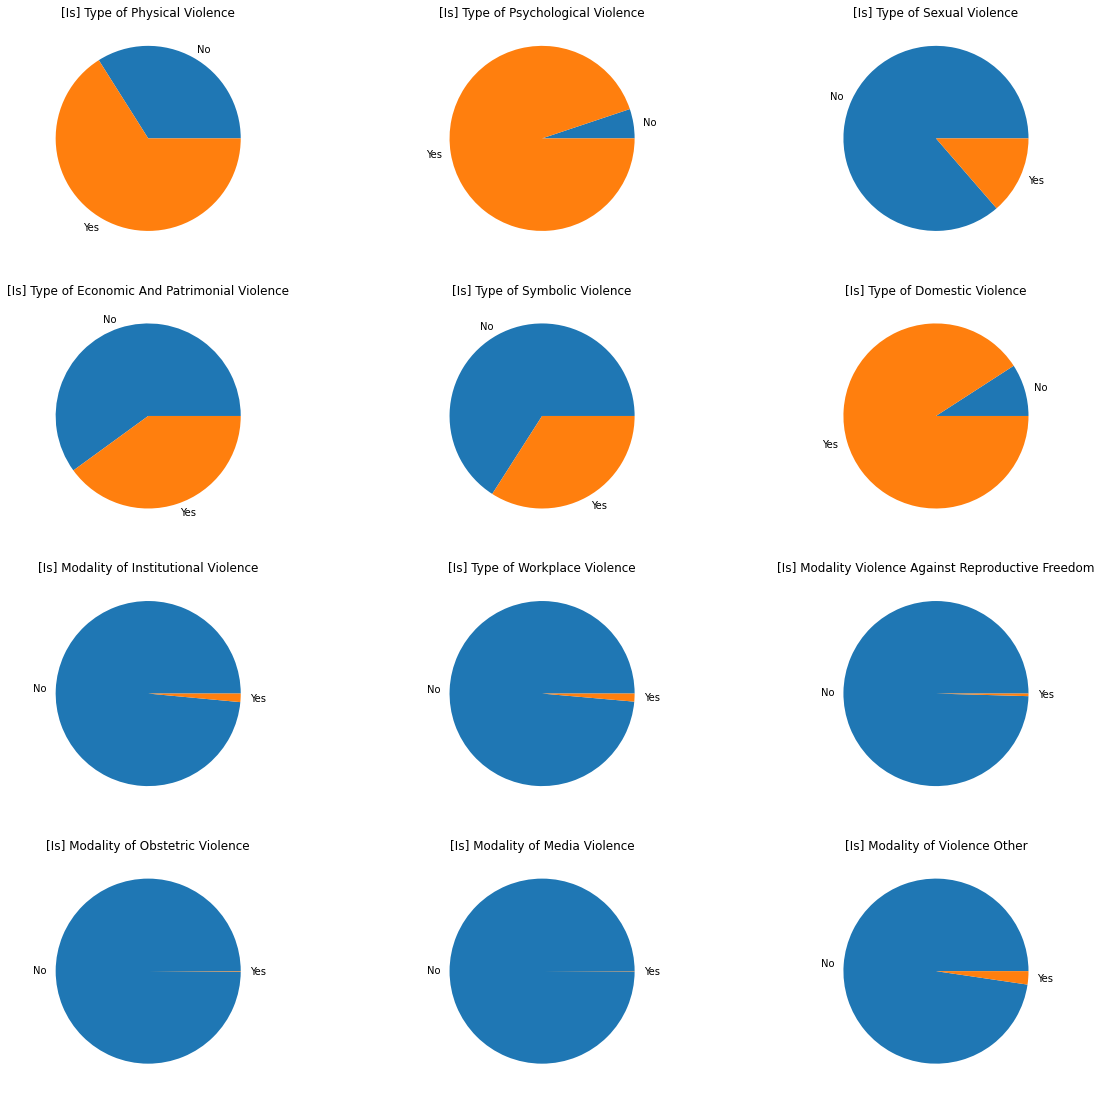

In [42]:
cols = 3
total = len(boolean_fields_dict)
rows = total // cols
rows += 1 if total % cols != 0 else rows
position = range(1, total + 1)

fig = plt.figure(1, figsize=(20,40))    
for k, id in enumerate(boolean_fields_dict):
    ax = fig.add_subplot(rows, cols, position[k])
    ax = data.groupby(id).size().plot(kind='pie', title= f'[Is] {boolean_fields_dict[id]}', labels=['No', 'Yes'])
    
plt.show()

### Distribution of victims by age

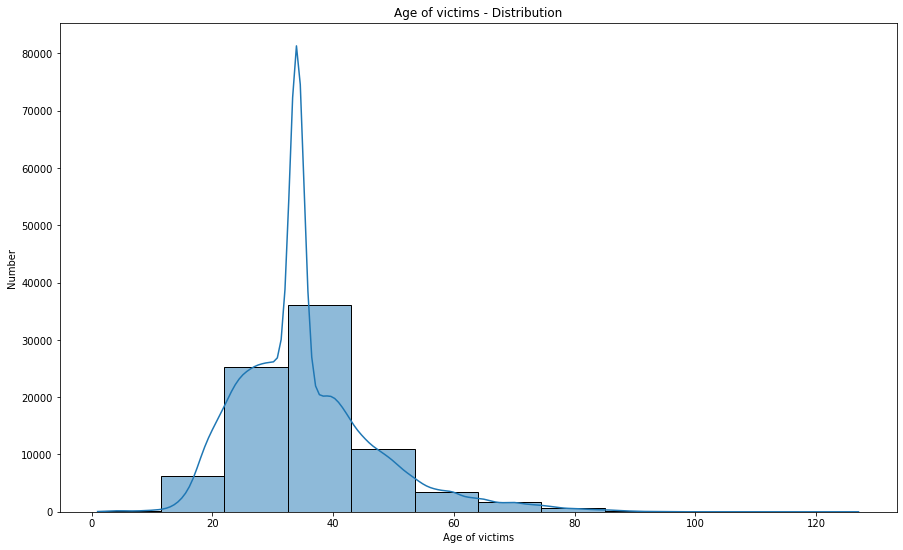

In [43]:

plt.figure(figsize=(15,9))
fig = sns.histplot(data['edad_persona_en_situacion_de_violencia'], bins=12, kde=True)
fig.set_title(('Age of victims - Distribution'))
fig.set_xlabel('Age of victims')
fig.set_ylabel('Number')
plt.show()

### Age average by gender

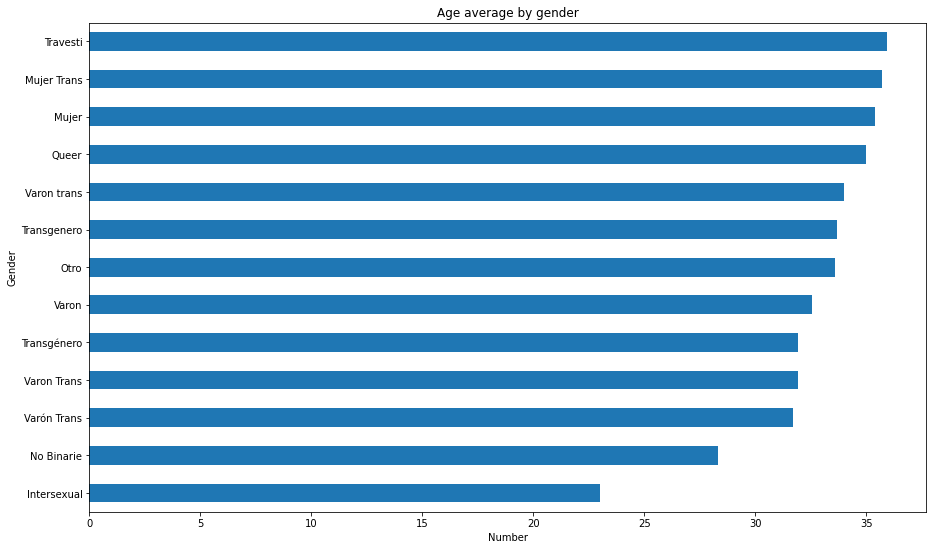

In [44]:

plt.figure(figsize=(15,9))
ax = data.groupby('genero_persona_en_situacion_de_violencia')['edad_persona_en_situacion_de_violencia'].mean() \
    .sort_values() \
    .plot(kind='barh', title='Age average by gender')
ax.set_xlabel('Number')
ax.set_ylabel('Gender')
plt.show()


### Victims by gender

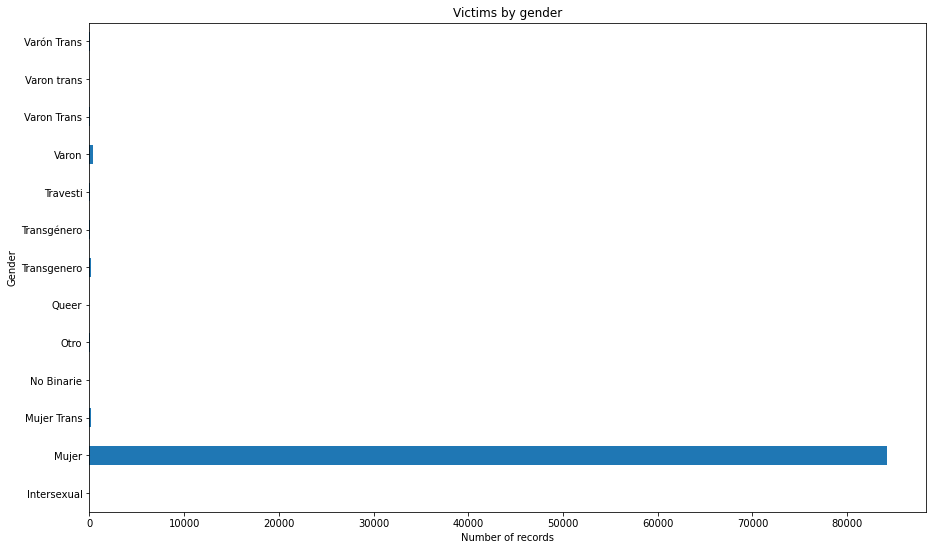

In [45]:

plt.figure(figsize=(15,9))
ax = data.groupby('genero_persona_en_situacion_de_violencia').size() \
    .plot(kind='barh', title='Victims by gender')

ax.set_ylabel('Gender')
ax.set_xlabel('Number of records')

plt.show()

### Adding column with month of call

In [46]:

def month(value):
    return value.month

def year(value):
    return value.year

data['month'] = data.fecha.map(month)
data['year'] = data.fecha.map(year)

data[['fecha', 'month', 'year']].sample(5)

,fecha,month,year
67367,2022-06-30,6,2022
4548,2020-03-01,3,2020
84782,2023-03-30,3,2023
15588,2020-07-05,7,2020
70493,2022-08-19,8,2022


### Calls by month

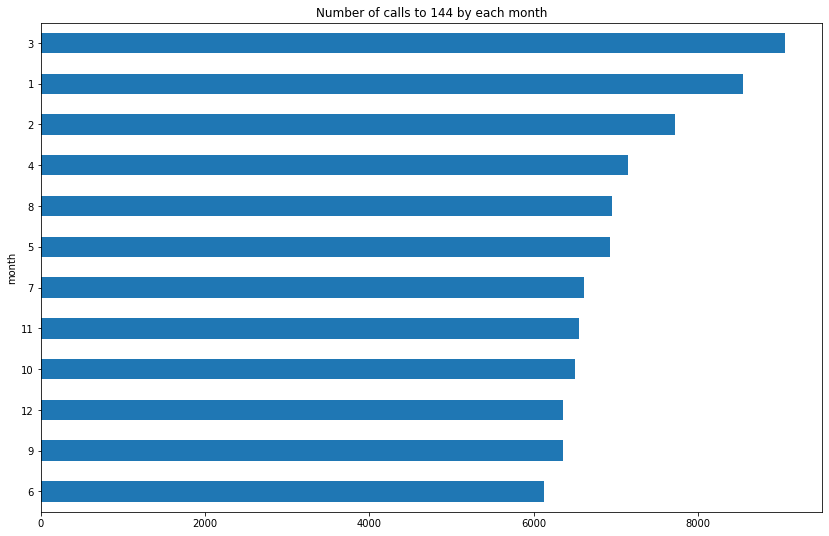

In [47]:

plt.figure(figsize=(14,9))
ax1 = data.groupby('month').size().sort_values() \
    .plot(kind='barh', title='Number of calls to 144 by each month')
plt.show()

### Mean and median of victims age

In [48]:
mean_age = data.edad_persona_en_situacion_de_violencia.mean()
median_age = data.edad_persona_en_situacion_de_violencia.median()

print(f'The mean age of victims is {round(mean_age, 0)} yo')
print(f'The median age of vinctims is {round(mean_age, 0)} yo')

The mean age of victims is 35.0 yo
The median age of vinctims is 35.0 yo


### Evolution (month, year) by age

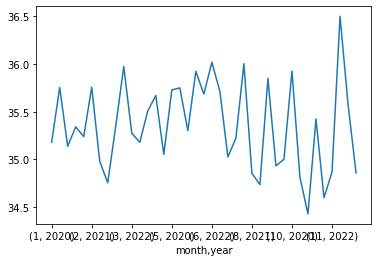

In [49]:
data.groupby(['month', 'year'])['edad_persona_en_situacion_de_violencia'].agg('mean').plot(kind='line')
plt.show()